# 2D Steady flow

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

<!-- This notebook was developed based on [this resource](https://yaredwb.github.io/FDM1D/) provided by [Dr. Y. Bekele](https://yaredwb.com/), and the book **An Introduction
to Soil Mechanics** by [A. Verruijt (2018)](https://doi.org/10.1007/978-3-319-61185-3). -->

You can execute this notebook interactively →  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/steady_flow_2D.ipynb)  or  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AppliedMechanics-EAFIT/soil_mechanics/main?filepath=notebooks/steady_flow_2D.ipynb)


<!-- ## Governing equation

The partial differential equation governing one-dimensional consolidation is given by the following diffussion equation:

$$
\frac{\partial p_\mathrm{w}}{\partial t} = c_\mathrm{v} \frac{\partial^2 p_\mathrm{w}}{\partial z^2}
$$

where $p_\mathrm{w}$ is the excess pore water pressure, $t$ stands for time, $z$ represents depth and $c_\mathrm{v}$ is the coefficient of consolidation which can be expressed as

$$
c_\mathrm{v} = \frac{k}{m_\mathrm{v} \gamma_w}
$$

with
- $k$: coefficient of permeability, 
- $m_\mathrm{v}$: the coefficient of volumetric compressibility, and 
- $\gamma_w$: the unit weight of water. -->

## Required modules and global setup for plots

In [1]:
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    # run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

# %matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)


In [31]:
def water_pressure_distrib_below_dam(L=15, B=5, D=5, H=5, Hw=5, δxy=1, n_lvls=15):
    L1 = L2 = 0.5 * (L - B)
    pts = {'O': (0, 0), 'A': (0, D), 'B': (L1, D), 'C': (L1+B, D), 'D': (L1+B+L2, D), 'E': (L1+B+L2, 0)}
    pts_x = [v[0] for v in pts.values()] + [pts['O'][0]]
    pts_y = [v[1] for v in pts.values()] + [pts['O'][1]]
    dam = {'H': (L1, D+H), 'B': pts['B'], 'C': pts['C']}
    dam_x = [v[0] for v in dam.values()] + [dam['H'][0]]
    dam_y = [v[1] for v in dam.values()] + [dam['H'][1]]

    # Grid spacing
    dx = dy = δxy  # Grid spacing
    # Generate a plot for the pressure distribution
    x = np.arange(0, L + dx, dx)
    y = np.arange(0, D + dy, dy)
    xx, yy = np.meshgrid(x, y)
    nx, ny = len(x), len(y)

    # Define the maximum number of iterations and a convergence criterion
    max_iter = 10000
    tol = 1e-3

    # Boundary conditions
    γw = 9.8  # kN/m³
    pressure_AB = Hw * γw  # Pressure at AB segment
    pressure_CD = 0  # Pressure at CD segment

    # Initialize the pressure grid
    pressure = np.zeros_like(xx).astype(float)

    # Apply boundary conditions

    # Segment AB (Horizontal line behind the dam)
    mask_AB = np.logical_and(xx <= pts['B'][0], yy == D)
    pressure[mask_AB] = pressure_AB 
    # Segment CD (Horizontal line in front of the dam)
    mask_CD = np.logical_and(xx >= pts['C'][0], yy == D)
    pressure[mask_CD] = pressure_CD
    # Segment BC (Base of the dam)
    mask_BC = np.logical_and(np.logical_and(xx > pts['B'][0], xx < pts['C'][0]), yy == D)
    mask_BC_below = np.logical_and(np.logical_and(xx > pts['B'][0], xx < pts['C'][0]), np.isclose(yy, D-dy, atol=0.1*dy))
    # pressure[mask_BC] = pressure_AB + (pressure_CD - pressure_AB) * (xx[mask_BC] - pts['B'][0]) / B
    # Segment OE (Horizontal line at the bottom of the domain - Impermeable boundary)
    mask_OE = np.logical_and(np.logical_and(xx >= pts['O'][0], xx <= pts['E'][0]), yy == 0)
    mask_OE_above = np.logical_and(np.logical_and(xx >= pts['O'][0], xx <= pts['E'][0]), np.isclose(yy, dy, atol=0.1*dy))
    # Segment OA (Vertical line at the left of the domain - Hidrostatic pressure condition)
    mask_OA = xx == pts['O'][0]
    pressure[mask_OA] = pressure_AB + γw * (D - yy[mask_OA])
    # Segment DE (Vertical line at the right of the domain - Hidrostatic pressure condition)
    mask_DE = xx == pts['E'][0]
    pressure[mask_DE] = pressure_CD + γw * (D - yy[mask_DE])

    # Gauss-Seidel iteration
    for it in range(max_iter):
        old_pressure = pressure.copy()

        # Update the pressure at each interior grid point
        for i, j in itertools.product(range(1, ny-1), range(1, nx-1)):
            pressure[i, j] = 0.25 * (pressure[i+1, j] + pressure[i-1, j] + pressure[i, j+1] + pressure[i, j-1])

        # Apply Neumann boundary condition (no normal flow) on OE and BC segments
        pressure[mask_OE] = pressure[mask_OE_above]
        pressure[mask_BC] = pressure[mask_BC_below]

        # Check for convergence
        if np.max(np.abs(pressure - old_pressure)) < tol:
            print(f'Convergence reached after {it+1} iterations.')
            break

    # Get velocity fields to plot the streamlines
    gradient = np.gradient(pressure, dx, dy)
    vel_x = -1e-5*gradient[1]
    vel_y = -1e-5*gradient[0]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    c = ax.contourf(xx, yy, pressure, cmap='Blues', alpha=.7, levels=n_lvls)  # Pressure distribution
    contour = ax.contour(xx, yy, pressure, colors='k', levels=n_lvls, linewidths=1, linestyles='dashed')
    # stream lines
    ax.streamplot(xx, yy, vel_x, vel_y, color='k', linewidth=1, density=0.5)
    # Boundaries
    ax.plot(pts_x, pts_y, ls='-', lw=2, c='k')  # Domain boundary
    ax.fill(dam_x, dam_y, color='gray', alpha=0.75)  # Dam area
    ax.plot(dam_x, dam_y, ls='-', lw=2, c='k')  # Dam boundary
    # Horizontal line for the water levels
    ax.hlines(y=D+Hw, xmin=pts['A'][0], xmax=pts['B'][0], color='#03719c', ls='--', lw=3)
    # Patch below water level
    ax.fill_between([pts['A'][0], pts['B'][0]], D, D+Hw, color='#03719c', alpha=0.25)
    ax.hlines(y=D, xmin=pts['C'][0], xmax=pts['D'][0], color='#03719c', ls='--', lw=3)

    fig.colorbar(c, ax=ax, label='Pressure [kPa]', orientation='horizontal', shrink=0.5)
    ax.set_xlabel('$x$  [m]')
    ax.set_ylabel('$z$  [m]')
    ax.grid(True, linestyle='--')
    ax.set_aspect('equal')#, adjustable='box')
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return pressure, xx, yy

def plot_pressure_at_dam_base(pressure, xx, yy, L, B, D, H, Hw, δxy):
    L1 = L2 = 0.5 * (L - B)
    # mask of the line at the dam's base
    mask = np.logical_and(np.isclose(yy, D, atol=0.1*δxy), np.logical_and(xx >= L1, xx <= L1+B))
    x, y, pw = xx[mask], yy[mask], pressure[mask]
    fig, ax = plt.subplots(figsize=(5, 3.5), layout='constrained')
    ax.plot(x, pw, ls='-', lw=2, c='b', marker='.')
    # Add text with the value at each node
    for i, txt in enumerate(pw):
        ax.annotate(f'{txt:.1f} kPa', (x[i], pw[i]), textcoords="offset points", xytext=(0, 5), ha='left')
    ax.set_xlabel('$x$  [m]')
    ax.set_ylabel('Water pressure [kPa]')
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.set(xlim=(xlim[0], 1.05*xlim[1]), ylim=(ylim[0], 1.05*ylim[1]))
    ax.grid(True, linestyle='--')
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()

def get_a_value(x, y, pressure, xx, yy):
    assert x >= 0 and x <= xx.max(), f'x must be within the domain [0, {xx.max()}]'
    assert y >= 0 and y <= yy.max(), f'y must be within the domain [0, {yy.max()}]'

    interpolator = sp.interpolate.RegularGridInterpolator((np.unique(yy), np.unique(xx)), pressure)
    return np.round(interpolator((y, x)), 3)


## Input data

In [25]:
D = 5  # Depth or vertical dimension of the domain
L = 20  # Length or horizontal dimension of the domain
B = 5  # Dam base length
H = 7  # Dam height
Hw = 0.9 * H  # Water height
δxy = 1 # Grid spacing

n_lvls = 12  # Number of contour levels  (optional, just for visualization)

## 2D Solution for the water pressure field

Convergence reached after 202 iterations.


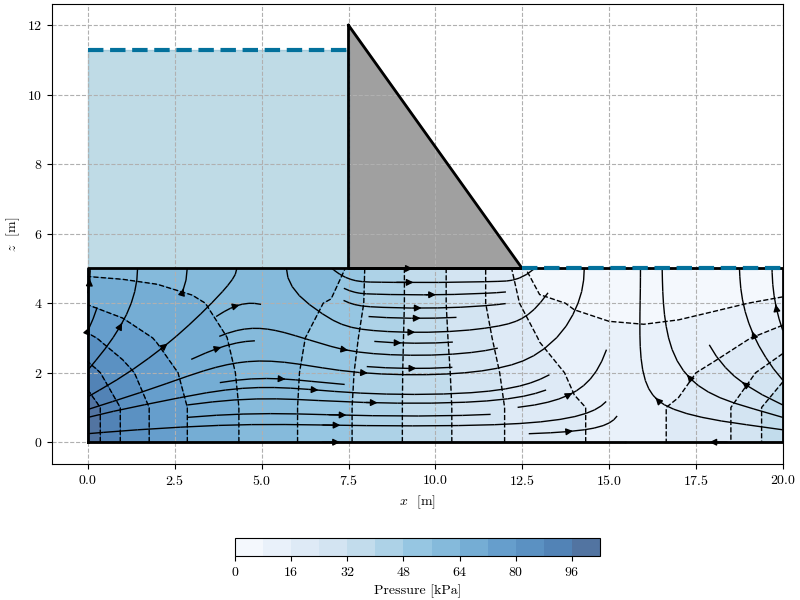

In [32]:
pressure, xx, yy = water_pressure_distrib_below_dam(L, B, D, H, Hw, δxy, n_lvls)

## Pressure distribution below the dam

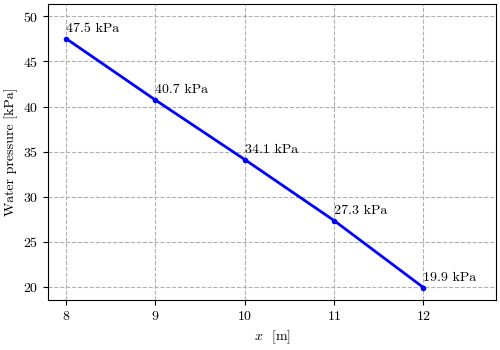

In [33]:
plot_pressure_at_dam_base(pressure, xx, yy, L, B, D, H, Hw, δxy)

## Pressure value at a point

In [35]:
x = 10  # x-coordinate of the point to evaluate the pressure
y = D  # y-coordinate of the point to evaluate the pressure

get_a_value(x, y, pressure, xx, yy)

34.109